In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import random
import warnings
from datetime import timedelta

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [2]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
full_list_date = pd.date_range(brent_data.index.min(), brent_data.index.max(), freq="D")
diff_list = set(full_list_date) - set(brent_data.index.unique())
print(f'Количество пропущенных дней: {len(diff_list)}')

Количество пропущенных дней: 621


In [4]:
full_data = pd.DataFrame(full_list_date, columns=['Date'], index=full_list_date)
full_data = full_data.join(brent_data, on='Date', how='left')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             3288 non-null   datetime64[ns]
 1   Значение         2667 non-null   float64       
 2   year             2667 non-null   float64       
 3   month            2667 non-null   float64       
 4   dayofmonth       2667 non-null   float64       
 5   quarter          2667 non-null   float64       
 6   dayofyear        2667 non-null   float64       
 7   weekofyear       2667 non-null   float64       
 8   dayofweek        2667 non-null   float64       
 9   is_holiday       2667 non-null   float64       
 10  is_prev_holiday  2667 non-null   float64       
 11  is_next_holiday  2667 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 333.9 KB


In [5]:
from datetime import timedelta
one_day = timedelta(days=1)

mas = full_data.loc[full_data['Значение'].isna(), ['Значение']].index



for i in mas:    
    min_day_value = None
    min_day = i
    while(True):
        min_day = min_day - one_day
        min_day_value = full_data.loc[min_day, ['Значение']].values[0]
        if min_day_value > 1:
            break;
            
    max_day_value = None
    max_day = i
    while(True):
        max_day = max_day + one_day
        max_day_value = full_data.loc[max_day, ['Значение']].values[0]
        if max_day_value > 1:
            break;
            
    full_data.loc[i, ['Значение']] = (max_day_value + min_day_value) / 2
    full_data.loc[i, ['year']] = i.year
    full_data.loc[i, ['month']] = i.month
    full_data.loc[i, ['dayofmonth']] = i.day
    full_data.loc[i, ['quarter']] = i.quarter
    full_data.loc[i, ['dayofyear']] = i.dayofyear
    full_data.loc[i, ['weekofyear']] = i.weekofyear
    full_data.loc[i, ['dayofweek']] = i.dayofweek
    full_data.loc[i, ['is_holiday']] = 0
    full_data.loc[i, ['is_prev_holiday']] = 0
    full_data.loc[i, ['is_next_holiday']] = 0

In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             3288 non-null   datetime64[ns]
 1   Значение         3288 non-null   float64       
 2   year             3288 non-null   float64       
 3   month            3288 non-null   float64       
 4   dayofmonth       3288 non-null   float64       
 5   quarter          3288 non-null   float64       
 6   dayofyear        3288 non-null   float64       
 7   weekofyear       3288 non-null   float64       
 8   dayofweek        3288 non-null   float64       
 9   is_holiday       3288 non-null   float64       
 10  is_prev_holiday  3288 non-null   float64       
 11  is_next_holiday  3288 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 493.9 KB


In [7]:
diff1 = np.array(full_data.iloc[1:,1].values - full_data.iloc[:-1,1].values).astype('float32') 
full_data['diff1'] = 0.0
full_data['diff1'] = full_data['diff1'].astype('float') 
full_data['diff1'].values[1:] = diff1

In [8]:
full_data.head()

,Date,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1
2010-09-01,2010-09-01,76.37,2010.0,9.0,1.0,3.0,244.0,35.0,2.0,0.0,0.0,0.0,0.00
2010-09-02,2010-09-02,76.89,2010.0,9.0,2.0,3.0,245.0,35.0,3.0,0.0,0.0,0.0,0.52
2010-09-03,2010-09-03,76.57,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.0,0.0,0.0,-0.32
2010-09-04,2010-09-04,76.62,2010.0,9.0,4.0,3.0,247.0,35.0,5.0,0.0,0.0,0.0,0.05
2010-09-05,2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,0.01


In [9]:
full_data.columns

Index(['Date', 'Значение', 'year', 'month', 'dayofmonth', 'quarter',
       'dayofyear', 'weekofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday', 'diff1'],
      dtype='object')

In [10]:
brent = full_data.drop(['Date', 'year', 'month', 'dayofmonth', 'quarter',
       'dayofyear', 'weekofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday'], axis=1)
brent.head()

,Значение,diff1
2010-09-01,76.37,0.00
2010-09-02,76.89,0.52
2010-09-03,76.57,-0.32
2010-09-04,76.62,0.05
2010-09-05,76.63,0.01


2. Добавьте первые разности по стоимости доллара и евро к рублю

In [11]:
USD = pd.read_csv('RC_F01_09_2010_T01_09_2019_USD.csv', sep=';', index_col=[0], parse_dates=[0], dayfirst=True)
USD['curs'] = USD['curs'].str.replace(',','.',regex=True)
USD['curs'] = USD['curs'].astype('float64')

diff_list_USD = set(full_list_date) - set(USD.index.unique())
print(f'Количество пропущенных дней: {len(diff_list_USD)}')

full_date = pd.DataFrame(full_list_date, index=full_list_date)

USD = pd.concat([pd.DataFrame(full_list_date, index=full_list_date), USD], axis=1)

USD = USD.loc[USD.index <= '2019-09-01']

bufer = full_date.merge(USD)
USD = pd.DataFrame(bufer['curs'].values, index=bufer[0], columns=['curs'])

mas = USD.loc[USD['curs'].isna(), ['curs']].index

for i in mas:    
    min_day_value = None
    min_day = i
    while(True):
        min_day = min_day - one_day
        if min_day < USD.index.min():
            break;
        min_day_value = USD.loc[min_day, ['curs']].values[0]
        if min_day_value > 1:
            break;
            
    max_day_value = None
    max_day = i
    while(True):
        max_day = max_day + one_day
        if max_day > USD.index.max():
            break;
        max_day_value = USD.loc[max_day, ['curs']].values[0]
        if max_day_value > 1:
            break;
    
    if max_day_value and min_day_value:
        USD.loc[i, ['curs']] = (max_day_value + min_day_value) / 2
    elif max_day_value:
        USD.loc[i, ['curs']] = max_day_value
    elif min_day_value:
        USD.loc[i, ['curs']] = min_day_value    
        
USD.info()    
USD.head(10)

Количество пропущенных дней: 1060
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   curs    3288 non-null   float64
dtypes: float64(1)
memory usage: 211.4 KB


,curs
0,
2010-09-01,30.866900
2010-09-02,30.800100
2010-09-03,30.685800
2010-09-04,30.692200
2010-09-05,30.634650
2010-09-06,30.605875
2010-09-07,30.577100
2010-09-08,30.731900
2010-09-09,30.887300


In [12]:
EUR = pd.read_csv('RC_F01_09_2010_T01_09_2019_EUR.csv', sep=';', index_col=[0], parse_dates=[0], dayfirst=True)
EUR['curs'] = EUR['curs'].str.replace(',','.',regex=True)
EUR['curs'] = EUR['curs'].astype('float64')

diff_list_EUR = set(full_list_date) - set(EUR.index.unique())
print(f'Количество пропущенных дней: {len(diff_list_EUR)}')

full_date = pd.DataFrame(full_list_date, index=full_list_date)

EUR = pd.concat([pd.DataFrame(full_list_date, index=full_list_date), EUR], axis=1)

EUR = EUR.loc[EUR.index <= '2019-09-01']

bufer = full_date.merge(EUR)
EUR = pd.DataFrame(bufer['curs'].values, index=bufer[0], columns=['curs'])

mas = EUR.loc[EUR['curs'].isna(), ['curs']].index

for i in mas:    
    min_day_value = None
    min_day = i
    while(True):
        min_day = min_day - one_day
        if min_day < EUR.index.min():
            break;
        min_day_value = EUR.loc[min_day, ['curs']].values[0]
        if min_day_value > 1:
            break;
            
    max_day_value = None
    max_day = i
    while(True):
        max_day = max_day + one_day
        if max_day > EUR.index.max():
            break;
        max_day_value = EUR.loc[max_day, ['curs']].values[0]
        if max_day_value > 1:
            break;
    
    if max_day_value and min_day_value:
        EUR.loc[i, ['curs']] = (max_day_value + min_day_value) / 2
    elif max_day_value:
        EUR.loc[i, ['curs']] = max_day_value
    elif min_day_value:
        EUR.loc[i, ['curs']] = min_day_value    
        
EUR.info()    
EUR.head(10)

Количество пропущенных дней: 1060
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   curs    3288 non-null   float64
dtypes: float64(1)
memory usage: 211.4 KB


,curs
0,
2010-09-01,39.012700
2010-09-02,39.165400
2010-09-03,39.290100
2010-09-04,39.350500
2010-09-05,39.411250
2010-09-06,39.441625
2010-09-07,39.472000
2010-09-08,39.321500
2010-09-09,39.294800


In [13]:
brent['USD'] = USD['curs'].values
brent['EUR'] = EUR['curs'].values
brent.head()

,Значение,diff1,USD,EUR
2010-09-01,76.37,0.00,30.86690,39.01270
2010-09-02,76.89,0.52,30.80010,39.16540
2010-09-03,76.57,-0.32,30.68580,39.29010
2010-09-04,76.62,0.05,30.69220,39.35050
2010-09-05,76.63,0.01,30.63465,39.41125


In [14]:
EUR_diff1 = np.array(brent.iloc[1:,3].values - brent.iloc[:-1,3].values).astype('float32') 
USD_diff1 = np.array(brent.iloc[1:,2].values - brent.iloc[:-1,2].values).astype('float32') 

brent['EUR_diff1'] = 0.0
brent['USD_diff1'] = 0.0

brent['EUR_diff1'] = brent['EUR_diff1'].astype('float') 
brent['USD_diff1'] = brent['USD_diff1'].astype('float') 

brent['EUR_diff1'].values[1:] = EUR_diff1 
brent['USD_diff1'].values[1:] = USD_diff1 

brent.head(20)

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1
2010-09-01,76.370,0.000,30.866900,39.012700,0.000000,0.000000
2010-09-02,76.890,0.520,30.800100,39.165400,0.152700,-0.066800
2010-09-03,76.570,-0.320,30.685800,39.290100,0.124700,-0.114300
2010-09-04,76.620,0.050,30.692200,39.350500,0.060400,0.006400
2010-09-05,76.630,0.010,30.634650,39.411250,0.060750,-0.057550
2010-09-06,76.870,0.240,30.605875,39.441625,0.030375,-0.028775
2010-09-07,77.260,0.390,30.577100,39.472000,0.030375,-0.028775
2010-09-08,77.930,0.670,30.731900,39.321500,-0.150500,0.154800
2010-09-09,77.210,-0.720,30.887300,39.294800,-0.026700,0.155400
2010-09-10,78.410,1.200,30.880100,39.186800,-0.108000,-0.007200


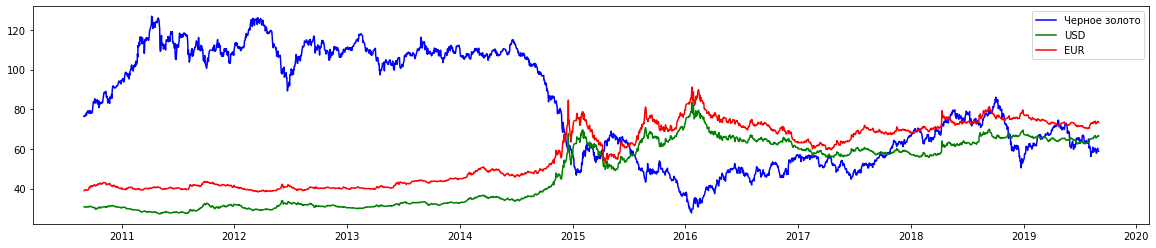

In [15]:
plt.figure(figsize =(20,4))
plt.plot(brent.index, brent['Значение'], 'b', label='Черное золото' )
plt.plot(brent.index, brent['USD'], 'g', label='USD' )
plt.plot(brent.index, brent['EUR'], 'r', label='EUR' )
plt.legend()
plt.show()

In [16]:
EUR.head(20)

,curs
0,
2010-09-01,39.012700
2010-09-02,39.165400
2010-09-03,39.290100
2010-09-04,39.350500
2010-09-05,39.411250
2010-09-06,39.441625
2010-09-07,39.472000
2010-09-08,39.321500
2010-09-09,39.294800


3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 

In [17]:
brent_w = brent.resample('w').mean()
brent_w.head()

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1
2010-09-05,76.616000,0.052000,30.735930,39.245990,0.079710,-0.046450
2010-09-12,77.830714,0.306429,30.766339,39.309432,-0.021950,0.021964
2010-09-19,78.608571,-0.077857,30.857300,39.979400,0.202707,0.034764
2010-09-26,78.568571,0.101429,30.968896,41.009032,0.080629,-0.035971
2010-10-03,81.574286,0.678571,30.548118,41.401061,0.082386,-0.039607


In [18]:
diff1 = np.array(brent_w.iloc[1:,0].values - brent_w.iloc[:-1,0].values).astype('float32') 
EUR_diff1 = np.array(brent_w.iloc[1:,3].values - brent_w.iloc[:-1,3].values).astype('float32') 
USD_diff1 = np.array(brent_w.iloc[1:,2].values - brent_w.iloc[:-1,2].values).astype('float32') 

brent_w['diff1'] = 0.0
brent_w['EUR_diff1'] = 0.0
brent_w['USD_diff1'] = 0.0

brent_w['diff1'].values[1:] = diff1
brent_w['EUR_diff1'].values[1:] = EUR_diff1 
brent_w['USD_diff1'].values[1:] = USD_diff1 

brent_w.head()

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1
2010-09-05,76.616000,0.000000,30.735930,39.245990,0.000000,0.000000
2010-09-12,77.830714,1.214714,30.766339,39.309432,0.063442,0.030409
2010-09-19,78.608571,0.777857,30.857300,39.979400,0.669968,0.090961
2010-09-26,78.568571,-0.040000,30.968896,41.009032,1.029632,0.111596
2010-10-03,81.574286,3.005714,30.548118,41.401061,0.392029,-0.420779


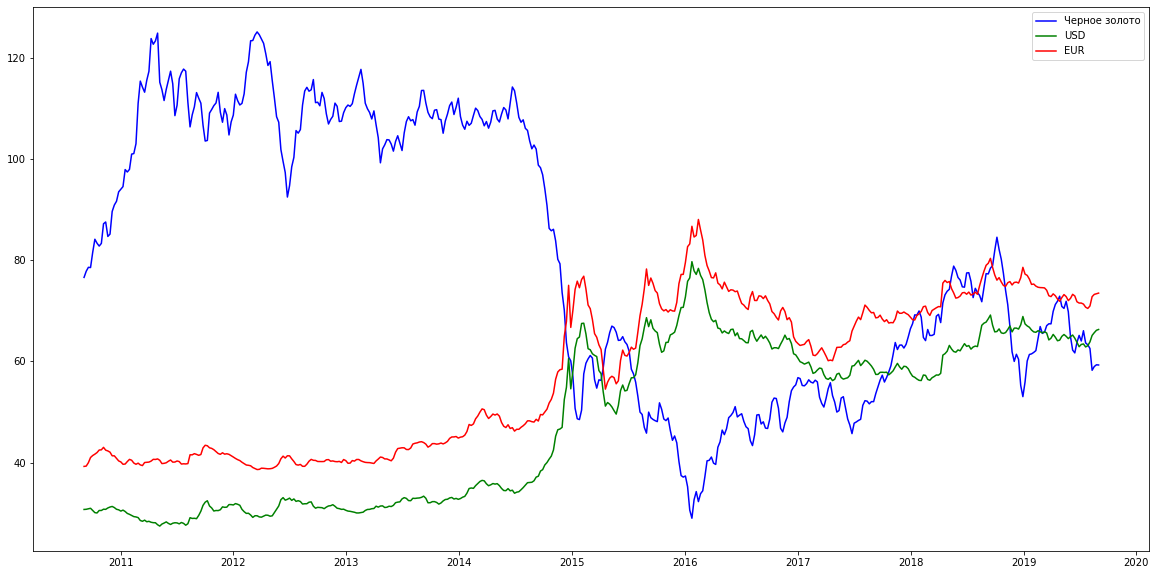

In [19]:
plt.figure(figsize =(20,10))
plt.plot(brent_w.index, brent_w['Значение'], 'b', label='Черное золото' )
plt.plot(brent_w.index, brent_w['USD'], 'g', label='USD' )
plt.plot(brent_w.index, brent_w['EUR'], 'r', label='EUR' )
plt.legend()
plt.show()

4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [20]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.preprocessing import StandardScaler

In [21]:
scl_target=StandardScaler() 

h=1
target = brent_w['Значение'].values[h:].reshape((brent_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(469, 1)

In [22]:
scl_x=StandardScaler() 

X = brent_w.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(469, 6)

In [23]:
def split_data( data, split_date ):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

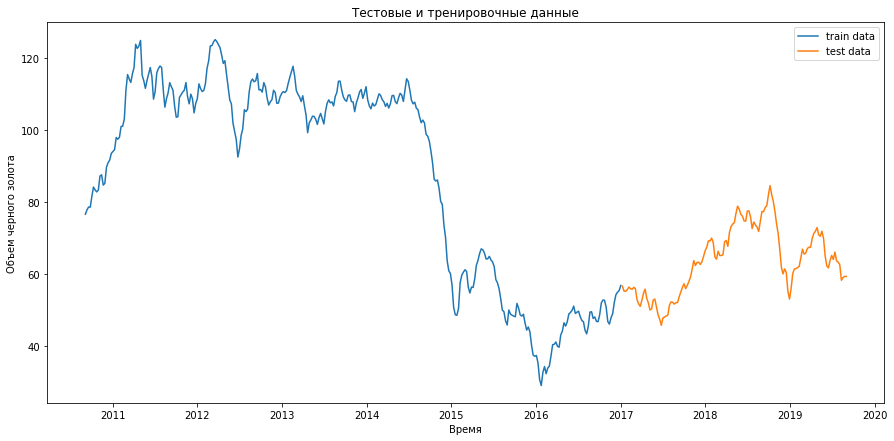

In [24]:
train, test = split_data( brent_w, '01-06-2017')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Объем черного золота')
plt.plot(train.index,train['Значение'], label='train data' )
plt.plot(test.index,test['Значение'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [25]:
X_train = X[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
model = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit( X_train, y_train )

GradientBoostingRegressor(max_depth=5, random_state=0)

In [28]:
y_pred = model.predict(X_test)

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

er_s = mean_squared_error(y_true=y_test, y_pred=y_pred) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_pred) 
er_r2 = r2_score(y_true=y_test, y_pred=y_pred)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.0413563914591114 
ошибка mae  :   0.15344092579524524 
оценка R2 :   0.6507768242622473


In [30]:
y_pred_all = model.predict(X)

In [31]:
y_pred_all_nscl = scl_target.inverse_transform(y_pred_all)

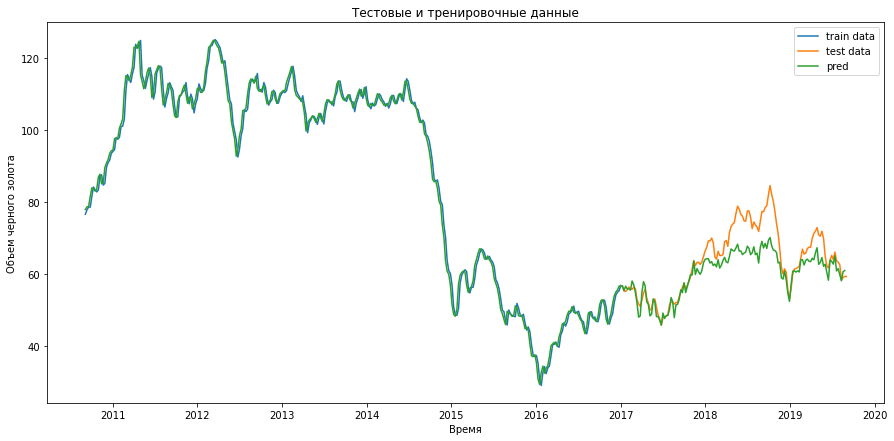

In [32]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Объем черного золота')
plt.plot(train.index,train['Значение'], label='train data' )
plt.plot(test.index,test['Значение'], label='test data')
plt.plot(brent_w.iloc[:-1].index,y_pred_all_nscl, label='pred')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

5. Добавьте еще один экзогенный фактор - любой:)

In [33]:
drag = pd.read_csv('drag.csv', sep=';', index_col=[0], parse_dates=[0], dayfirst=True)

colum_data = drag.columns

full_date = pd.DataFrame(full_list_date, index=full_list_date)

drag = drag.loc[drag.index < brent_data.index.max()]
drag = drag.loc[drag.index > brent_data.index.min()]

for col in colum_data:
    drag[col] = drag[col].str.replace(',','.',regex=True)
    drag[col] = drag[col].astype('float64')

diff_list_drag = set(full_list_date) - set(drag.index.unique())
print(f'Количество пропущенных дней: {len(diff_list_drag)}')

drag = full_date.merge(drag, how='left', left_index=True, right_index=True)
drag = drag.drop([0], axis=1)


for col in colum_data:
    mas = drag.loc[drag[col].isna(), [col]].index
    for i in mas:    
        min_day_value = None
        min_day = i
        while(True):
            min_day = min_day - one_day
            if min_day < drag.index.min():
                break;
            min_day_value = drag.loc[min_day, [col]].values[0]
            if min_day_value > 1:
                break;

        max_day_value = None
        max_day = i
        while(True):
            max_day = max_day + one_day
            if max_day > drag.index.max():
                break;
            max_day_value = drag.loc[max_day, [col]].values[0]
            if max_day_value > 1:
                break;

        if max_day_value and min_day_value:
            drag.loc[i, [col]] = (max_day_value + min_day_value) / 2
        elif max_day_value:
            drag.loc[i, [col]] = max_day_value
        elif min_day_value:
            drag.loc[i, [col]] = min_day_value    
        
drag.info()    
drag.head(10)

Количество пропущенных дней: 1061
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Золото    3288 non-null   float64
 1   Серебро   3288 non-null   float64
 2   Платина   3288 non-null   float64
 3   Палладий  3288 non-null   float64
dtypes: float64(4)
memory usage: 288.4 KB


,Золото,Серебро,Платина,Палладий
2010-09-01,1237.8100,18.690,1513.1000,503.0400
2010-09-02,1237.8100,18.690,1513.1000,503.0400
2010-09-03,1230.9900,19.210,1517.3500,512.0300
2010-09-04,1235.4400,19.190,1534.4400,519.0400
2010-09-05,1231.8950,19.260,1536.4750,519.5450
2010-09-06,1230.1225,19.295,1537.4925,519.7975
2010-09-07,1228.3500,19.330,1538.5100,520.0500
2010-09-08,1232.3500,19.620,1533.4600,517.7400
2010-09-09,1249.2600,19.510,1543.2000,520.3600
2010-09-10,1244.5000,19.880,1541.8500,518.2500


In [34]:
brent_drag = brent.copy()

In [35]:
brent_drag['Gold'] = drag['Золото'].values
brent_drag['Silver'] = drag['Серебро'].values
brent_drag['Platinum'] = drag['Платина'].values
brent_drag['Palladium'] = drag['Палладий'].values
brent_drag.head()

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1,Gold,Silver,Platinum,Palladium
2010-09-01,76.37,0.00,30.86690,39.01270,0.00000,0.00000,1237.810,18.69,1513.100,503.040
2010-09-02,76.89,0.52,30.80010,39.16540,0.15270,-0.06680,1237.810,18.69,1513.100,503.040
2010-09-03,76.57,-0.32,30.68580,39.29010,0.12470,-0.11430,1230.990,19.21,1517.350,512.030
2010-09-04,76.62,0.05,30.69220,39.35050,0.06040,0.00640,1235.440,19.19,1534.440,519.040
2010-09-05,76.63,0.01,30.63465,39.41125,0.06075,-0.05755,1231.895,19.26,1536.475,519.545


In [36]:
Gold_diff1 = np.array(brent_drag.iloc[1:,6].values - brent_drag.iloc[:-1,6].values).astype('float32') 
Silver_diff1 = np.array(brent_drag.iloc[1:,7].values - brent_drag.iloc[:-1,7].values).astype('float32') 
Platinum_diff1 = np.array(brent_drag.iloc[1:,8].values - brent_drag.iloc[:-1,8].values).astype('float32') 
Palladium_diff1 = np.array(brent_drag.iloc[1:,9].values - brent_drag.iloc[:-1,9].values).astype('float32') 

brent_drag['Gold_diff1'] = 0.0
brent_drag['Silver_diff1'] = 0.0
brent_drag['Platinum_diff1'] = 0.0
brent_drag['Palladium_diff1'] = 0.0

brent_drag['Gold_diff1'] = brent_drag['Gold_diff1'].astype('float') 
brent_drag['Silver_diff1'] = brent_drag['Silver_diff1'].astype('float') 
brent_drag['Platinum_diff1'] = brent_drag['Platinum_diff1'].astype('float') 
brent_drag['USD_diff1'] = brent_drag['USD_diff1'].astype('float')

brent_drag['Gold_diff1'].values[1:] = Gold_diff1 
brent_drag['Silver_diff1'].values[1:] = Silver_diff1 
brent_drag['Platinum_diff1'].values[1:] = Platinum_diff1 
brent_drag['Palladium_diff1'].values[1:] = Palladium_diff1 

brent_drag.head(20)

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1,Gold,Silver,Platinum,Palladium,Gold_diff1,Silver_diff1,Platinum_diff1,Palladium_diff1
2010-09-01,76.370,0.000,30.866900,39.012700,0.000000,0.000000,1237.8100,18.6900,1513.1000,503.0400,0.000000,0.0000,0.000000,0.0000
2010-09-02,76.890,0.520,30.800100,39.165400,0.152700,-0.066800,1237.8100,18.6900,1513.1000,503.0400,0.000000,0.0000,0.000000,0.0000
2010-09-03,76.570,-0.320,30.685800,39.290100,0.124700,-0.114300,1230.9900,19.2100,1517.3500,512.0300,-6.820000,0.5200,4.250000,8.9900
2010-09-04,76.620,0.050,30.692200,39.350500,0.060400,0.006400,1235.4400,19.1900,1534.4400,519.0400,4.450000,-0.0200,17.090000,7.0100
2010-09-05,76.630,0.010,30.634650,39.411250,0.060750,-0.057550,1231.8950,19.2600,1536.4750,519.5450,-3.545000,0.0700,2.035000,0.5050
2010-09-06,76.870,0.240,30.605875,39.441625,0.030375,-0.028775,1230.1225,19.2950,1537.4925,519.7975,-1.772500,0.0350,1.017500,0.2525
2010-09-07,77.260,0.390,30.577100,39.472000,0.030375,-0.028775,1228.3500,19.3300,1538.5100,520.0500,-1.772500,0.0350,1.017500,0.2525
2010-09-08,77.930,0.670,30.731900,39.321500,-0.150500,0.154800,1232.3500,19.6200,1533.4600,517.7400,4.000000,0.2900,-5.050000,-2.3100
2010-09-09,77.210,-0.720,30.887300,39.294800,-0.026700,0.155400,1249.2600,19.5100,1543.2000,520.3600,16.910000,-0.1100,9.740000,2.6200
2010-09-10,78.410,1.200,30.880100,39.186800,-0.108000,-0.007200,1244.5000,19.8800,1541.8500,518.2500,-4.760000,0.3700,-1.350000,-2.1100


In [37]:
brent_drag_w = brent_drag.resample('w').mean()
brent_drag_w.head()

,Значение,diff1,USD,EUR,EUR_diff1,USD_diff1,Gold,Silver,Platinum,Palladium,Gold_diff1,Silver_diff1,Platinum_diff1,Palladium_diff1
2010-09-05,76.616000,0.052000,30.735930,39.245990,0.079710,-0.046450,1234.789000,19.008000,1522.893000,511.339000,-1.183000,0.114000,4.675000,3.301000
2010-09-12,77.830714,0.306429,30.766339,39.309432,-0.021950,0.021964,1236.882500,19.601429,1538.833214,518.981786,0.195714,0.067857,-0.239286,-0.334286
2010-09-19,78.608571,-0.077857,30.857300,39.979400,0.202707,0.034764,1253.598929,20.136071,1572.193571,537.436786,6.379286,0.146429,11.779285,4.291429
2010-09-26,78.568571,0.101429,30.968896,41.009032,0.080629,-0.035971,1282.827143,20.869286,1622.498214,542.943929,0.957143,0.032857,1.096429,0.637143
2010-10-03,81.574286,0.678571,30.548118,41.401061,0.082386,-0.039607,1281.180714,21.225000,1617.077857,551.283214,0.641429,0.085000,1.620000,0.760714


In [38]:
diff1 = np.array(brent_drag_w.iloc[1:,0].values - brent_drag_w.iloc[:-1,0].values).astype('float32') 
Gold_diff1 = np.array(brent_drag_w.iloc[1:,6].values - brent_drag_w.iloc[:-1,6].values).astype('float32') 
Silver_diff1 = np.array(brent_drag_w.iloc[1:,7].values - brent_drag_w.iloc[:-1,7].values).astype('float32') 
Platinum_diff1 = np.array(brent_drag_w.iloc[1:,8].values - brent_drag_w.iloc[:-1,8].values).astype('float32') 
Palladium_diff1 = np.array(brent_drag_w.iloc[1:,9].values - brent_drag_w.iloc[:-1,9].values).astype('float32') 

brent_drag_w['diff1'] = 0.0
brent_drag_w['Gold_diff1'] = 0.0
brent_drag_w['Silver_diff1'] = 0.0
brent_drag_w['Platinum_diff1'] = 0.0
brent_drag_w['Palladium_diff1'] = 0.0

brent_drag_w['diff1'].values[1:] = diff1
brent_drag_w['Gold_diff1'].values[1:] = Gold_diff1 
brent_drag_w['Silver_diff1'].values[1:] = Silver_diff1 
brent_drag_w['Platinum_diff1'].values[1:] = Platinum_diff1 
brent_drag_w['Palladium_diff1'].values[1:] = Palladium_diff1 

brent_drag_w = brent_drag_w.drop(['USD', 'EUR', 'EUR_diff1', 'USD_diff1'], axis=1)
brent_drag_w.head()

,Значение,diff1,Gold,Silver,Platinum,Palladium,Gold_diff1,Silver_diff1,Platinum_diff1,Palladium_diff1
2010-09-05,76.616000,0.000000,1234.789000,19.008000,1522.893000,511.339000,0.000000,0.000000,0.000000,0.000000
2010-09-12,77.830714,1.214714,1236.882500,19.601429,1538.833214,518.981786,2.093500,0.593429,15.940214,7.642786
2010-09-19,78.608571,0.777857,1253.598929,20.136071,1572.193571,537.436786,16.716429,0.534643,33.360355,18.455000
2010-09-26,78.568571,-0.040000,1282.827143,20.869286,1622.498214,542.943929,29.228214,0.733214,50.304642,5.507143
2010-10-03,81.574286,3.005714,1281.180714,21.225000,1617.077857,551.283214,-1.646429,0.355714,-5.420357,8.339286


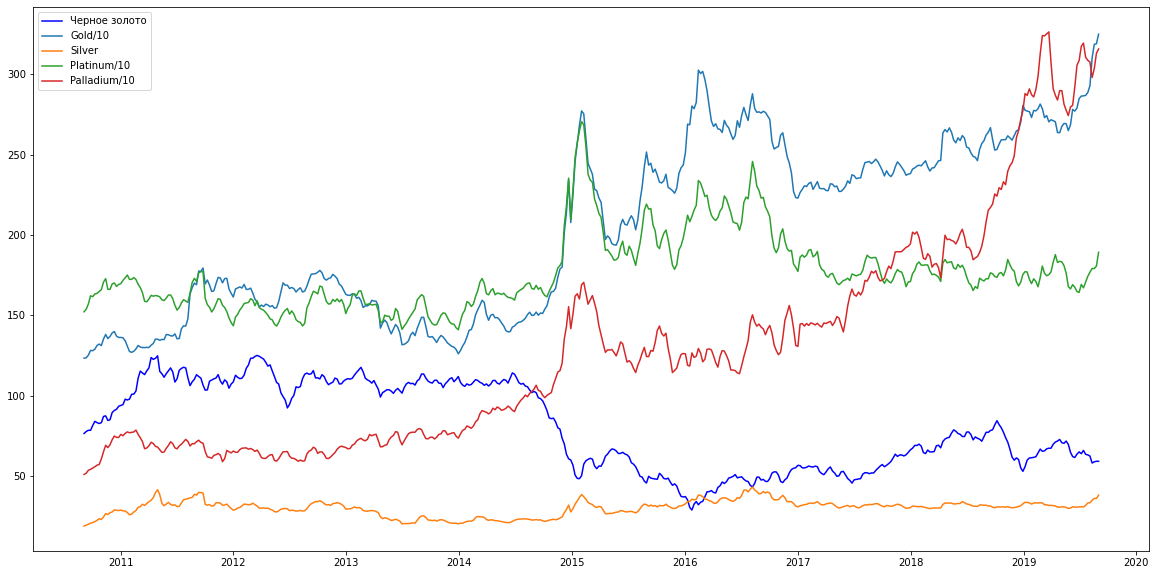

In [39]:
plt.figure(figsize =(20,10))
plt.plot(brent_drag_w.index, brent_drag_w['Значение'], 'b', label='Черное золото' )
plt.plot(brent_drag_w.index, brent_drag_w['Gold']/10, label='Gold/10' )
plt.plot(brent_drag_w.index, brent_drag_w['Silver'], label='Silver' )
plt.plot(brent_drag_w.index, brent_drag_w['Platinum']/10, label='Platinum/10' )
plt.plot(brent_drag_w.index, brent_drag_w['Palladium']/10, label='Palladium/10' )
plt.legend()
plt.show()

In [40]:
scl_target=StandardScaler() 

target = brent_drag_w['Значение'].values[h:].reshape((brent_drag_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

scl_x=StandardScaler() 

X = brent_drag_w.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

X_train = X[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

model = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model.fit( X_train, y_train )

y_pred = model.predict(X_test)

er_s = mean_squared_error(y_true=y_test, y_pred=y_pred) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_pred) 
er_r2 = r2_score(y_true=y_test, y_pred=y_pred)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.021579469904545828 
ошибка mae  :   0.11290727047384336 
оценка R2 :   0.8177778392910909


In [41]:
y_pred_all = model.predict(X)
y_pred_all_nscl = scl_target.inverse_transform(y_pred_all)

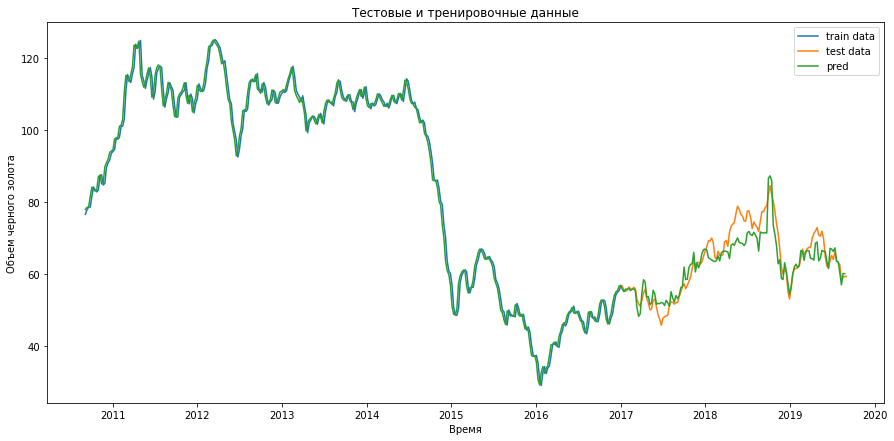

In [42]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Объем черного золота')
plt.plot(train.index,train['Значение'], label='train data' )
plt.plot(test.index,test['Значение'], label='test data')
plt.plot(brent_w.iloc[:-1].index,y_pred_all_nscl, label='pred')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

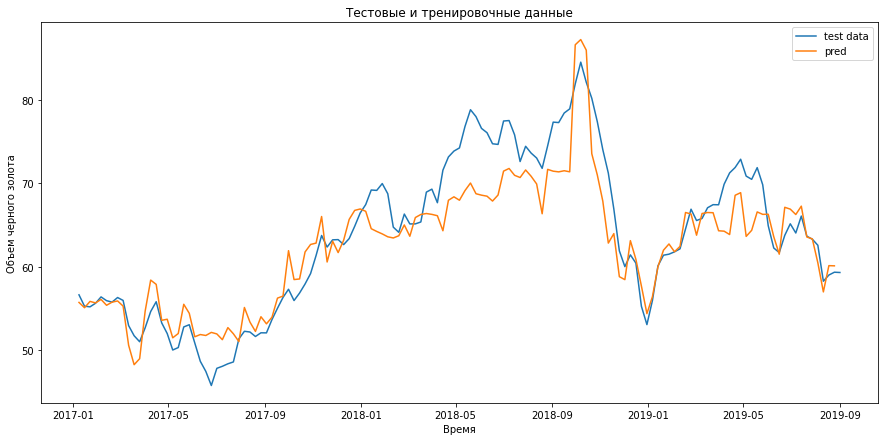

In [45]:
y_pred = model.predict(X_test)
y_pred_nscl = scl_target.inverse_transform(y_pred)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Объем черного золота')
plt.plot(test.index,test['Значение'], label='test data')
plt.plot(brent_w.iloc[train.shape[0]:-1,:].index, y_pred_nscl, label='pred')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()


6. Сравните модель с дополнительным экзогенным фактором и исходную и сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

На 2ой модели ошибка уменьшилась, значит метал цена драг металла более коррелирует с ценой нефти чем цена бумажки.

На самом деле, если всмотреться в график, то на такой модели не заработаешь.